In [1]:
import numpy as np
import gpstk
from GNSS_TK1 import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stations=[[["/mnt/zob1324.03.n","/mnt/zob1324.03.o"],["/mnt/garf324.03.n","/mnt/garf324.03.o"],"GPS 8"],
          [["/mnt/erla324.03.n","/mnt/erla324.03.o"],["/mnt/leba324.03.n","/mnt/leba324.03.o"],"GPS 28"],
          [["/mnt/colb324.03.n","/mnt/colb324.03.o"],["/mnt/mtvr324.03.n","/mnt/mtvr324.03.o"],"GPS 28"],
          #[["/mnt/kntn324.03.n","/mnt/kntn324.03.o"],["/mnt/sidn324.03.n","/mnt/sidn324.03.n"],"GPS 28"],
          [["/mnt/woos324.03.n","/mnt/woos324.03.o"],["/mnt/garf324.03.n","/mnt/garf324.03.o"],"GPS 26"],
          #[["/mnt/lsbn324.03.n","/mnt/lsbn324.03.o"],["/mnt/freo324.03.n","/mnt/freo324.03.o"],"GPS 26"],
         ]

In [3]:
def datajump(lI,threshold=0.5): #Input: lI=L1-L2, times. Detects jumps in data depending on a threshold
    jumps=[]
    jumps=np.where(np.abs(np.diff(np.hstack(([0],lI))))>threshold) 
    return jumps[0] 

Funciones

In [4]:
def gradients(stations):
    for pair in stations:
        st1=pair[0]
        st2=pair[1]
        satellite=pair[2]
        print "##################################################################"
        print "Station 1:",st1[0][5:9]

        print "\nStation 2:",st2[0][5:9]

        t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2,L11,L12,L21,L22,C11,C12,C21,C22=getdata_stationpair(st1,st2,satellite)
        obs1=get_arcs(t1,Icode1,Iphase1,ELEV1,IPP1,L11,L12,C11,C12) #gets arcs with Phase, Code, and adjusted times observations
        obs2=get_arcs(t2,Icode2,Iphase2,ELEV2,IPP2,L21,L22,C21,C22) #L11 estacion 1 frec 1
        
        gamma=gpstk.GAMMA_GPS

        for arc in range(len(obs1)):#to each arc observed in a day
            print "*************Arc #"+str(arc+1)+"*************"
            time1=obs1[arc][0] #times on station 1 same arc!
            time2=obs2[arc][0] #times on station 2

            tboth=np.intersect1d(time1,time2)
            print "\n# Times in common: ",tboth.size

            #Now we take observations in both stations
            t1index=np.array([i for i in range(time1.size) if time1[i] in tboth ])
            t2index=np.array([i for i in range(time2.size) if time2[i] in tboth ])

            time1=time1[t1index] 
            time2=time2[t2index]

            Phase1=obs1[arc][1][t1index]
            Phase2=obs2[arc][1][t2index]

            Code1=obs1[arc][2][t1index]
            Code2=obs2[arc][2][t2index]

            Elevation1=obs1[arc][3][t1index]
            Elevation2=obs2[arc][3][t2index]

            #Phase on frequency L1,L2 station1
            Phase1L1=obs1[arc][4][t1index]
            Phase1L2=obs1[arc][5][t1index]
            Code1L1=obs1[arc][6][t1index]
            Code1L2=obs1[arc][7][t1index]

            #Phase on frequency L1,L2 station 2
            Phase2L1=obs2[arc][4][t2index]
            Phase2L2=obs2[arc][5][t2index]
            Code2L1=obs2[arc][6][t2index]
            Code2L2=obs2[arc][7][t2index]
            
            #Ionospheric pearce points
            DIPP1=getIPPS(IPP1,tboth)
            DIPP2=getIPPS(IPP2,tboth)
            

            D=[]
            for i in tboth:
                d=np.sqrt((DIPP1[i][0]-DIPP2[i][0])**2+(DIPP1[i][1]-DIPP2[i][1])**2+(DIPP1[i][2]-DIPP2[i][2])**2)
                D.append(d)
            
            D=np.array(D)

            #Detect data jumps on L1-L2
            jumps1=datajump(Phase1,2.5)
            jumps2=datajump(Phase2,2.5)
            
            #Detect Multipass cycle slips
            #MP1 & MP2 In station 1
            MP11=Code1L1-(1+(2/(gamma-1)))*Phase1L1 + (2/(gamma-1))*Phase1L2
            MP12=Code1L2-((2*gamma*Phase1L1)/(gamma-1))+(((2*gamma)/(gamma-1))-1)*Phase1L2
            jumpsMP11=datajump(MP11,threshold=10)
            jumpsMP12=datajump(MP12,threshold=10)
            
            #MP1 & MP2 In station 2
            MP21=Code2L1-(1+(2/(gamma-1)))*Phase2L1 + (2/(gamma-1))*Phase2L2
            MP22=Code2L2-((2*gamma*Phase2L1)/(gamma-1))+(((2*gamma)/(gamma-1))-1)*Phase2L2
            jumpsMP21=datajump(MP21,threshold=10)
            jumpsMP22=datajump(MP22,threshold=10)
            
            print "Cycle slips",jumps1
            print "Multipath",jumpsMP11
            print "Multipath",jumpsMP12
    
            
            #Divide in Sub-arcs using jumps
            miniarcs1=sub_arcs(Phase1,jumps1)
            miniarcs2=sub_arcs(Phase2,jumps2)
            #print "\nSubarcs st1: ",miniarcs1
            #print "\nSubarcs st2: ",miniarcs2

            #Remove short arcs 
            print "\nRemove short arcs"
            if len(jumps1)>0:
                miniarcs1,miniarcs2=remove_short(miniarcs1,miniarcs2)
            if len(jumps2)>0:
                miniarcs2,miniarcs1=remove_short(miniarcs2,miniarcs1)

            #Polinomial fit and Outlier Detection
            ##On each subarc check for slips and delete.
            pslips1=[] #slips in st1 with polinomyal fit
            pslips2=[] #slips in st2 with polinomyal fit
            oslips1=[] #slips in st1 oulier factor
            oslips2=[] #slips in st2 oulier factor

            for i in range(len(miniarcs1)):#In station1
                __,pslip=poly_fit(Phase1[miniarcs1[i]],time1[miniarcs1[i]])
                pslips1.append(pslip)
                __,oslip=outlier_detect(Phase1[miniarcs1[i]],time1[miniarcs1[i]]*3600)
                oslips1.append(oslip)

            for i in range(len(miniarcs2)):#In station2
                __,pslip=poly_fit(Phase2[miniarcs2[i]],time2[miniarcs2[i]])
                pslips2.append(pslip)
                __,oslip=outlier_detect(Phase2[miniarcs2[i]],time2[miniarcs2[i]]*3600)
                oslips2.append(oslip)

            ##Using polinompyal fit and outlier factor methods we confirm slips
            confirmed1=[] #a list of lists with the confirmed outliers on each subarc
            confirmed2=[]

            for i in range(len(miniarcs1)):
                outliers=confirmed_slip(time1[miniarcs1[i]],Phase1[miniarcs1[i]])
                confirmed1.append(outliers)

            for i in range(len(miniarcs2)):
                outliers=confirmed_slip(time2[miniarcs2[i]],Phase2[miniarcs2[i]])
                confirmed2.append(outliers) 

            #Remove slips from both stations
            for i in range(len(confirmed1)):
                if len(confirmed1[i])!=0:
                    miniarcs1[i],miniarcs2=remove_slip(miniarcs1[i],miniarcs2,oslips1[i])

            for i in range(len(confirmed2)):
                if len(confirmed2[i])!=0:
                    miniarcs2[i],miniarcs1=remove_slip(miniarcs2[i],miniarcs1,oslips2[i])
            
            #Leveling Phase

            PhaseArc1=[] #list with subarcs leveled
            PhaseArc2=[]
            C1,C2=[],[]
            PhaseL11,PhaseL12=[],[]
            PhaseL21,PhaseL22=[],[]
            IPPD=[]
        
            for i in range(len(miniarcs1)):
                Lfactor,new_IPHASE_arc=levelphase(Code1[miniarcs1[i]],Phase1[miniarcs1[i]],Elevation1[miniarcs1[i]])
                PhaseArc1.append(new_IPHASE_arc)  
                C1.append(Code1[miniarcs1[i]])
                PhaseL11.append(Phase1L1[miniarcs1[i]])
                PhaseL12.append(Phase1L2[miniarcs1[i]])
                IPPD.append(D[miniarcs1[i]]) #aqui aprovecho para quedarme con las distancias entre IPPs de los puntos buenos
            
            for i in range(len(miniarcs2)):
                Lfactor,new_IPHASE_arc=levelphase(Code2[miniarcs2[i]],Phase2[miniarcs2[i]],Elevation2[miniarcs2[i]])
                PhaseArc2.append(new_IPHASE_arc)
                C2.append(Code2[miniarcs2[i]])
                PhaseL21.append(Phase2L1[miniarcs2[i]])
                PhaseL22.append(Phase2L2[miniarcs2[i]])
                
            #print IPPD
            new_IPHASE_arc1=np.hstack(PhaseArc1) 
            new_IPHASE_arc2=np.hstack(PhaseArc2)
            C1=np.hstack(C1)
            C2=np.hstack(C2)
            L11=np.hstack(PhaseL11)
            L12=np.hstack(PhaseL12)
            L21=np.hstack(PhaseL21)
            L22=np.hstack(PhaseL22)
            IPPD=np.hstack(IPPD)
            ntimes1=np.array([])
            ntimes2=np.array([])
            

            for i in miniarcs1:
                ntimes1=np.append(ntimes1,time1[i])

            for i in miniarcs2:
                ntimes2=np.append(ntimes2,time2[i])
            print "# Observations st1: ",ntimes1.size,new_IPHASE_arc1.size
            print "# Observations st2: ",ntimes2.size,new_IPHASE_arc2.size
            print "# Distances: ",IPPD.size
            

            plt.figure(figsize=(16,10))

            plt.subplot(4,3,1)
            title="For arc #"+str(arc+1)+"Station 1 Phase "+st1[0][5:9]
            plt.title(title)
            plt.scatter(ntimes1/3600,new_IPHASE_arc1,color="blue")

            plt.subplot(4,3,2)
            title="For arc #"+str(arc+1)+"Station 2 Phase "+st2[0][5:9]
            plt.title(title)
            plt.scatter(ntimes2/3600,new_IPHASE_arc2,color="blue")

            plt.subplot(4,3,3)
            title="Gradient Phase"+st1[0][5:9]+"-"+st2[0][5:9]
            plt.title(title)
            IONO=(new_IPHASE_arc1-new_IPHASE_arc2)*1000 #mm
            d=IPPD/1000 #Km
            #new_IPHASE_arc1-new_IPHASE_arc2
            plt.scatter(ntimes2/3600,IONO/d,color="red",alpha=0.5)
            plt.plot(ntimes2/3600,IONO/d,color="red")
            print "Biggest grdient: ",np.max(IONO/d)
            print "Time of biggest gradient: ",ntimes2[np.argmax(IONO/d)]/3600

            plt.subplot(4,3,4)
            title="For arc #"+str(arc+1)+"Station 1 Code "+st1[0][5:9]
            plt.title(title)
            plt.scatter(ntimes1/3600,C1,color="green")

            plt.subplot(4,3,5)
            title="For arc #"+str(arc+1)+"Station 2 Code "+st2[0][5:9]
            plt.title(title)
            plt.scatter(ntimes2/3600,C2,color="green")

            plt.subplot(4,3,6)
            title="Gradient Code "+st1[0][5:9]+st2[0][5:9]
            plt.title(title)
            IONO=(C1-C2)*1000 #mm
            d=IPPD/1000 #Km
            plt.scatter(ntimes2/3600,IONO/d,color="red",alpha=.7)
            plt.plot(ntimes2/3600,IONO/d,color="red")

            plt.subplot(4,3,7)
            title="Phase L1 arc #"+str(arc+1)+"Station 1 "+st1[0][5:9]
            plt.title(title)
            plt.scatter(ntimes2/3600,L11,color="red")

            plt.subplot(4,3,8)
            title="Phase L2 arc #"+str(arc+1)+"Station 1"+st1[0][5:9]
            plt.title(title)
            plt.scatter(ntimes2/3600,L12,color="red")

            plt.subplot(4,3,10)
            title="Phase L1 arc #"+str(arc+1)+"Station 2"+st2[0][5:9]
            plt.title(title)
            plt.scatter(ntimes2/3600,L21,color="red")


            plt.subplot(4,3,11)
            title="Phase L2 arc #"+str(arc+1)+"Station 2"+st2[0][5:9]
            plt.title(title)
            plt.scatter(ntimes2/3600,L21,color="red")
            
            




##################################################################
Station 1: zob1

Station 2: garf
*************Arc #1*************

# Times in common:  108
Cycle slips [0]
Multipath [0]
Multipath [  0   7   8   9  11  12  16  18  19  20  22  23  24  25  31  35  36  37
  43  44  46  47  52  61  66  67  68  72  84  85  88  98 106 107]

Remove short arcs
# Observations st1:  107 107
# Observations st2:  107 107
# Distances:  107
Biggest grdient:  295.006929055
Time of biggest gradient:  5.71666666667
*************Arc #2*************

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)




# Times in common:  632
Cycle slips [  0 148 168 169 177 179 375 376 377 378]
Multipath [  0 148 168 169 177 179 376 377 378]
Multipath [  0   3   4   5   6   8  10  20  21  22  23  25  43  44 148 168 169 177
 179 180 376 377 378 622 623 624 625]

Remove short arcs
# Observations st1:  608 608
# Observations st2:  608 608
# Distances:  608
Biggest grdient:  490.861332442
Time of biggest gradient:  20.9916666667
##################################################################
Station 1: erla

Station 2: leba
*************Arc #1*************

# Times in common:  154
Cycle slips [0]
Multipath [0]
Multipath [0]

Remove short arcs
# Observations st1:  154 154
# Observations st2:  154 154
# Distances:  154
Biggest grdient:  286.45684995
Time of biggest gradient:  1.275
*************Arc #2*************

# Times in common:  638
Cycle slips [  0   1   2 298 299 300 301 303]
Multipath [  0   1   2 299 300 301 302 303]
Multipath [  0   1   2 299 300 301 303]

Remove short arcs
# Observations 

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)




# Times in common:  628
Cycle slips [  0 276]
Multipath [  0 277 278]
Multipath [  0 277 278]

Remove short arcs
# Observations st1:  627 627
# Observations st2:  627 627
# Distances:  627
Biggest grdient:  411.592253679
Time of biggest gradient:  21.025
##################################################################
Station 1: woos

Station 2: garf
*************Arc #1*************

# Times in common:  629
Cycle slips [0]
Multipath [0]
Multipath [0]

Remove short arcs
# Observations st1:  629 629
# Observations st2:  629 629
# Distances:  629
Biggest grdient:  68.4517748191
Time of biggest gradient:  4.05
*************Arc #2*************

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)




# Times in common:  123
Cycle slips [  3   4   5   7   8   9  10  12  13  15  16  17  20  21  22  24  25  26
  31  32 107 108 109 118 119 120 121]
Multipath [  0   1   2   3   4   5   7   8   9  10  12  13  15  16  17  20  21  22
  23  24  25  26  31  32 107 108 109 118 119 120 121]
Multipath [  3   4   5   7   8   9  10  12  13  15  16  17  20  21  22  23  24  25
  26  31  32 107 108 109 118 119 120 121]

Remove short arcs
# Observations st1:  59 59
# Observations st2:  59 59
# Distances:  59
Biggest grdient:  429.132137316
Time of biggest gradient:  21.2916666667


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


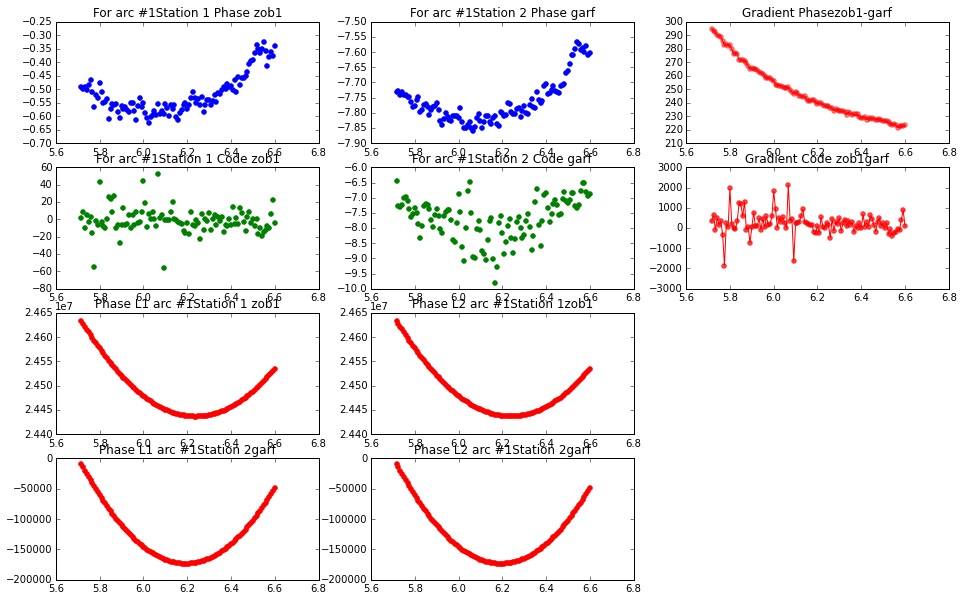

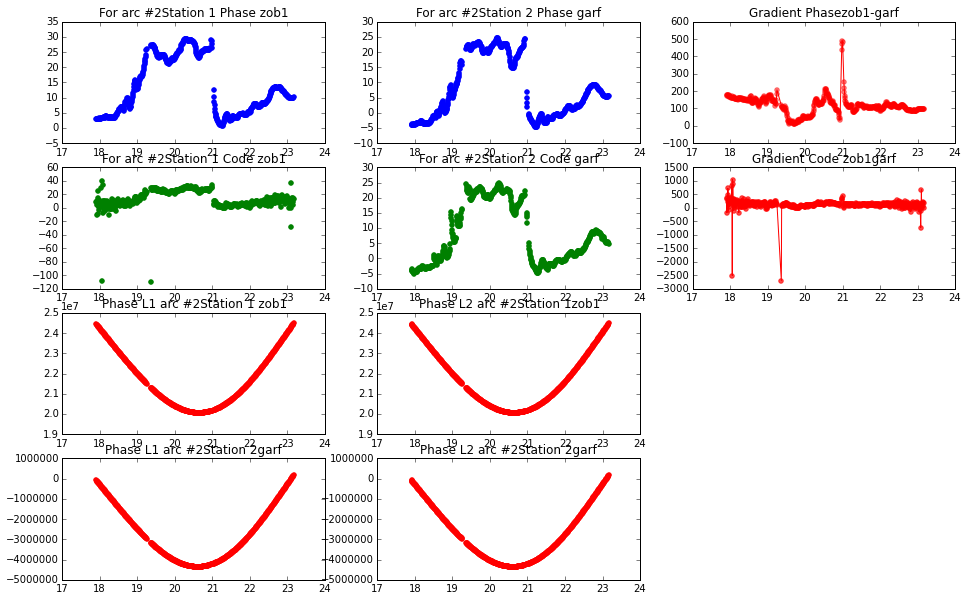

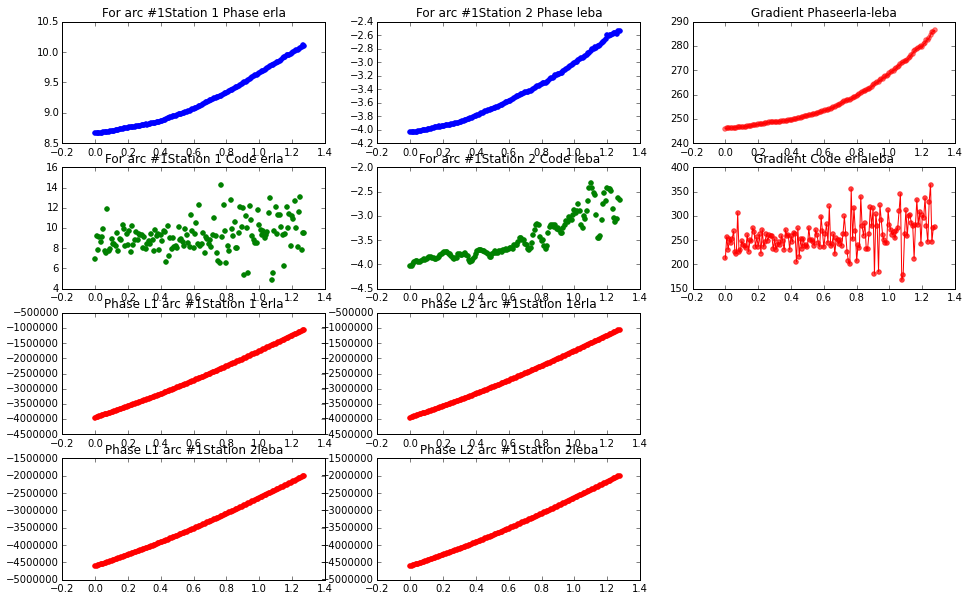

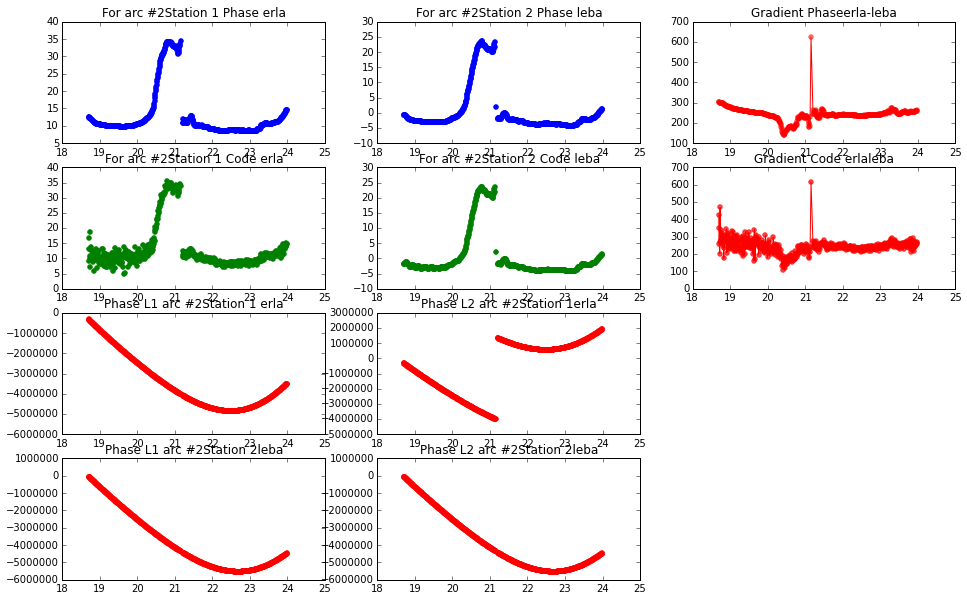

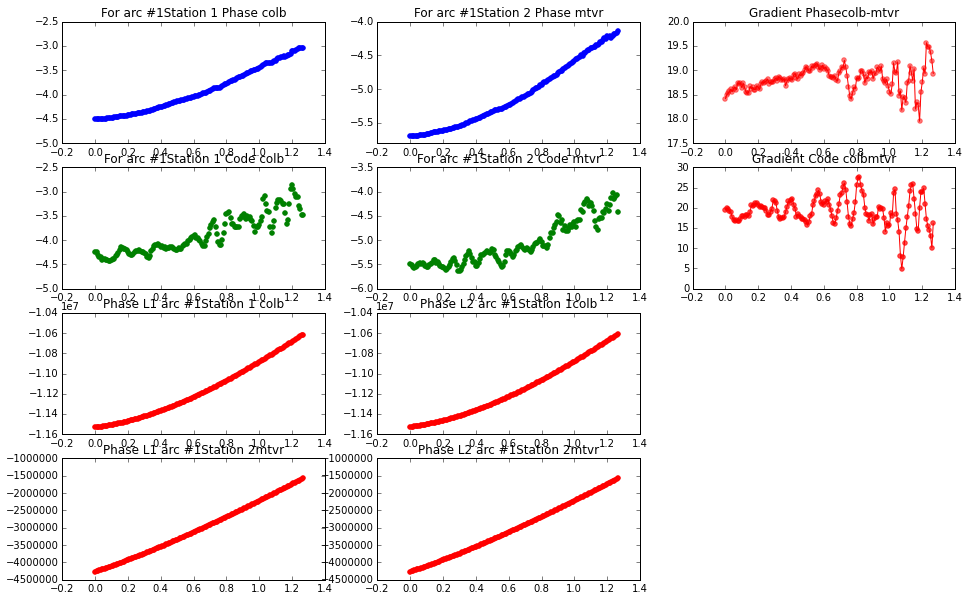

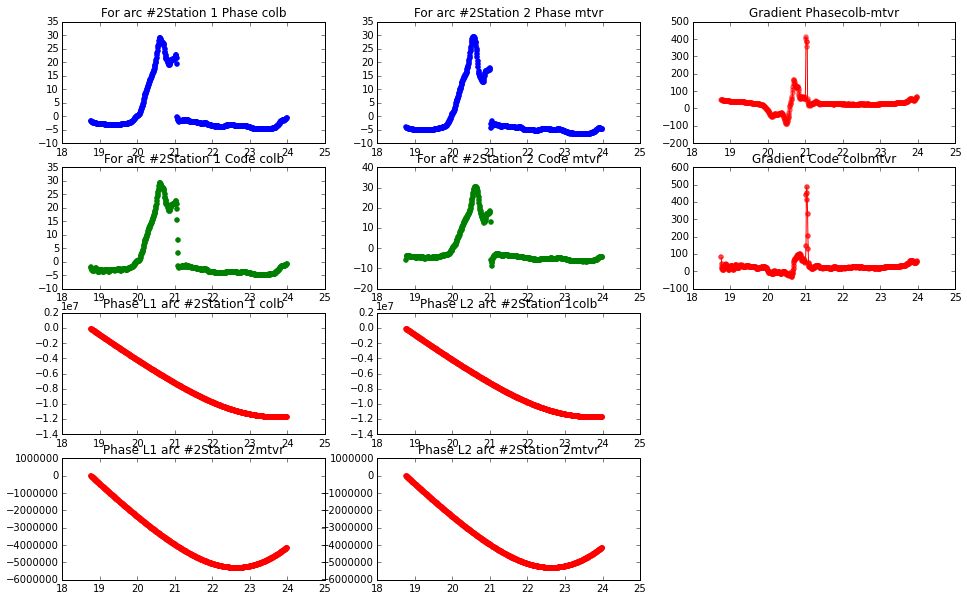

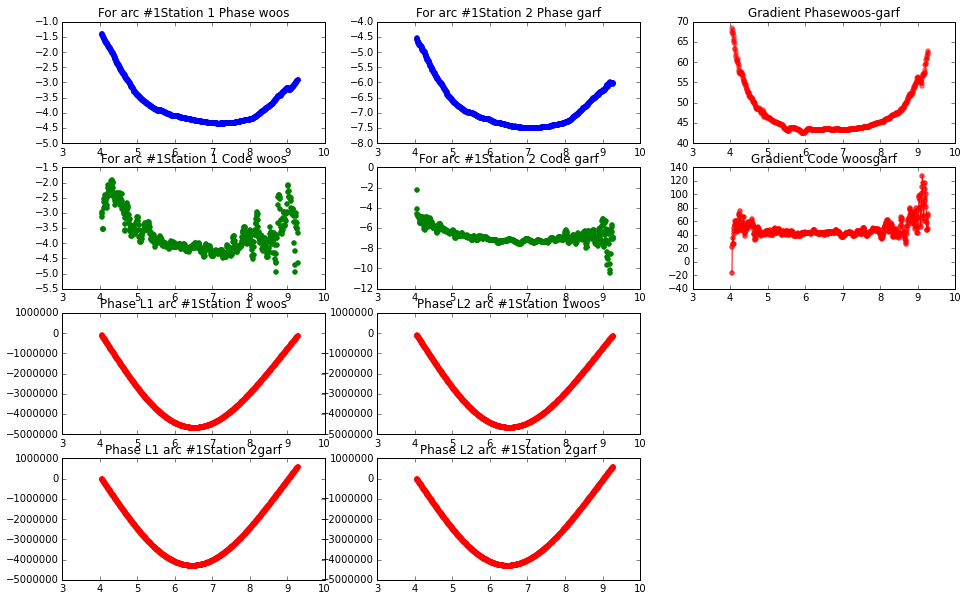

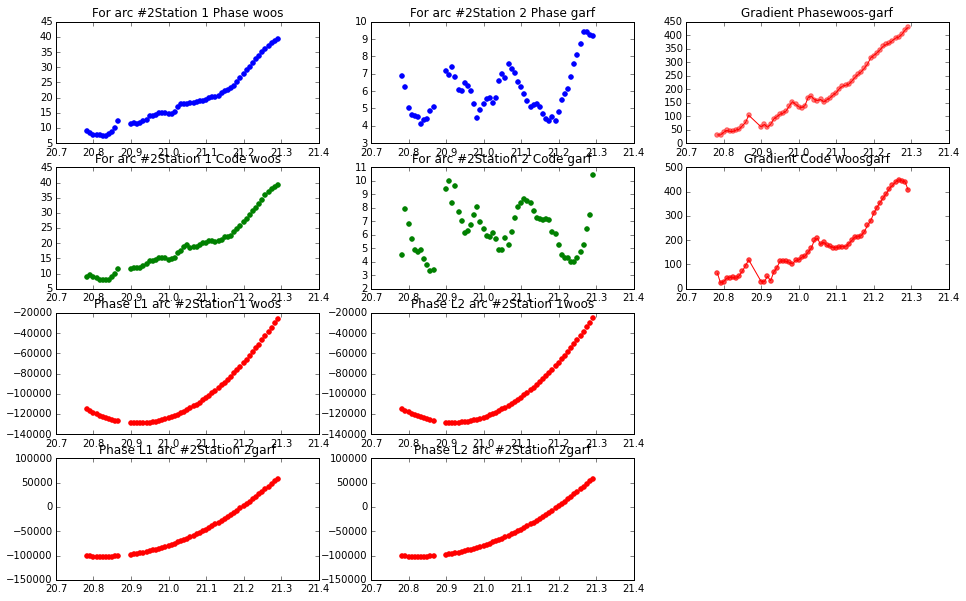

In [5]:
gradients(stations)